# Create a 3 layer conv net that gets over 65% test accuracy

The idea here is to make go over the search space and see what is even possible. So create a bunch of models over the search space and try and over fit the data. This will generate a refined search space to work in. There isn't really a point to keeping these models around as for the first step we are only looking at the training accuracy.

* Start by looking at the entire search space for learning rate, regularization strength, number of filters, and number of hidden neurons.


In [1]:
# As usual, a bit of setup

import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.cnn import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient_array, eval_numerical_gradient
from cs231n.layers import *
from cs231n.fast_layers import *
from cs231n.solver import Solver


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [64]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.iteritems():
  print '%s: ' % k, v.shape

X_val:  (1000, 3, 32, 32)
X_train:  (49000, 3, 32, 32)
X_test:  (1000, 3, 32, 32)
y_val:  (1000,)
y_train:  (49000,)
y_test:  (1000,)


In [73]:
from cs231n.classifiers.cnn_crp_a_soft import *
from cs231n.layers import *
from cs231n.layer_utils import *


#data that is used to test if a model can overfit data. If it cannot overfit, ignore the model
num_overfit = 20
overfit_data = {
  'X_train': data['X_train'][:num_overfit],
  'y_train': data['y_train'][:num_overfit],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

# This is the number of total models to make. The
num_points = 1000

lr_range = [1e-9,1e-3]
reg_range = [1e-9,1e-1]
#ws_range = [.009, .05]
#num_filters_range = [10,65] # is not end inclusive
#hidden_dim_range = [50,501]# is not end inclusive

lr = np.random.rand(num_points)*(lr_range[1]-lr_range[0])+lr_range[0]
reg = np.random.rand(num_points)*(reg_range[1]-reg_range[0])+reg_range[0]
#ws = np.random.rand(num_points)*(ws_range[1]-ws_range[0])+ws_range[0]
#num_filters = (np.random.rand(num_points)*(num_filters_range[1]-num_filters_range[0])+num_filters_range[0]).astype(np.int)
#hidden_dim = (np.random.rand(num_points)*(hidden_dim_range[1]-hidden_dim_range[0])+hidden_dim_range[0]).astype(np.int)


# initialize the score recorder
training_score = np.zeros(num_points)

In [74]:
#create the models and train on overfit data

for ii in xrange(num_points):
    mod = ThreeLayerConvNet(num_filters=16, filter_size=3,
                       hidden_dim=100, num_classes=10, weight_scale=0.025, reg=reg[ii],
                       dtype=np.float32)
    
    solver = Solver(mod, overfit_data,
                num_epochs=4, batch_size=5,
                update_rule='adam',
                optim_config={
                  'learning_rate': lr[ii],
                },
                verbose=False, print_every=100)
    solver.train()
    solver.train_acc_history
    training_score[ii] = solver.train_acc_history[-1]
    print "Completed model %d/%d, %.1f%% complete.\t Training Score: %.1f%%" %(ii, num_points, (ii+1e-5)/num_points*100, training_score[ii]*100)

(Iteration 1 / 16) loss: 7.149030
Completed model 0/1000, 0.0% complete.	 Training Score: 75.0%
(Iteration 1 / 16) loss: 6.972414
Completed model 1/1000, 0.1% complete.	 Training Score: 100.0%
(Iteration 1 / 16) loss: 12.756360
Completed model 2/1000, 0.2% complete.	 Training Score: 90.0%
(Iteration 1 / 16) loss: 5.220001
Completed model 3/1000, 0.3% complete.	 Training Score: 95.0%
(Iteration 1 / 16) loss: 11.477999
Completed model 4/1000, 0.4% complete.	 Training Score: 60.0%
(Iteration 1 / 16) loss: 10.982320
Completed model 5/1000, 0.5% complete.	 Training Score: 65.0%
(Iteration 1 / 16) loss: 3.325512
Completed model 6/1000, 0.6% complete.	 Training Score: 85.0%
(Iteration 1 / 16) loss: 10.075047
Completed model 7/1000, 0.7% complete.	 Training Score: 80.0%
(Iteration 1 / 16) loss: 7.235077
Completed model 8/1000, 0.8% complete.	 Training Score: 95.0%
(Iteration 1 / 16) loss: 3.563817
Completed model 9/1000, 0.9% complete.	 Training Score: 100.0%
(Iteration 1 / 16) loss: 8.345544


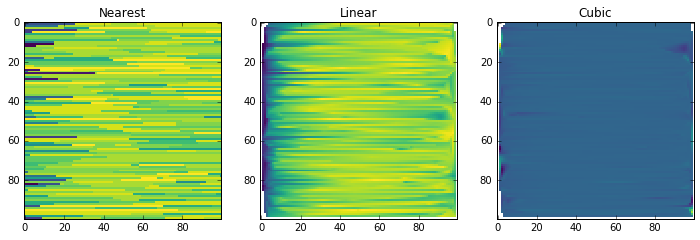

In [87]:
# move all the data into one ndarray so it can be interpolated
data_points = np.zeros([num_points,2])
data_points[:,0] =lr
data_points[:,1] = reg



from scipy.interpolate import griddata
import matplotlib.pyplot as plt

grid_x, grid_y = np.mgrid[lr_range[0]:lr_range[1]:100j, reg_range[0]:reg_range[1]:100j]

grid_z0 = griddata(data_points, training_score, (grid_x, grid_y), method='nearest')
grid_z1 = griddata(data_points, training_score, (grid_x, grid_y), method='linear')
grid_z2 = griddata(data_points, training_score, (grid_x, grid_y), method='cubic')


plt.subplot(131)
#plt.imshow(func(grid_x, grid_y).T, extent=(0,1,0,1), origin='lower')
#plt.plot(data_points[:,0], data_points[:,1], 'k.', ms=1)
#plt.title('Original')

#plt.subplot(132)
plt.imshow(grid_z0.T,cmap = 'viridis')
#plt.imshow(grid_z0.T, extent=(0,1,0,1), origin='lower')
plt.title('Nearest')
plt.subplot(132)
plt.imshow(grid_z1.T,cmap = 'viridis')
plt.title('Linear')
plt.subplot(133)
plt.imshow(grid_z2.T,cmap = 'viridis')
plt.title('Cubic')

plt.gcf().set_size_inches(12,12)
plt.show()


In [ ]:
# Train a really good model on CIFAR-10

from cs231n.classifiers.cnn_crp_a_soft import *
from cs231n.layers import *
from cs231n.layer_utils import *

#data that is used to test if a model can overfit data. If it cannot overfit, ignore the model
num_overfit = 20
overfit_data = {
  'X_train': data['X_train'][:num_overfit],
  'y_train': data['y_train'][:num_overfit],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

num_points = 10

lr_range = [-4,-2]
reg_range = [-8,-2]
ws_range = [.009, .05]
num_filters_range = [10,64]
hidden_dim_range = [50,500]

solvers = []
num_models_tried = 0 # number of times new parameters were created 
while len(solvers) < num_points:
    num_models_tried +=1
    print "Found %d of %d models, on iteration %d" %(len(solvers),num_points,num_models_tried)
    # generate a new set of parameters given the ranges above
    learning_rate = 10**np.random.uniform(lr_range[0], lr_range[1])
    reg_val = 10**np.random.uniform(reg_range[0], reg_range[1])
    weight_scale = 10**np.random.uniform(np.log10(ws_range[0]), np.log10(ws_range[1]))
    num_filters = np.random.uniform(num_filters_range[0], num_filters_range[1],1)[0].astype(np.int)
    hidden_dim = np.random.uniform(hidden_dim_range[0], hidden_dim_range[1],1)[0].astype(np.int)

    #print "learning_rate: %.3e \nreg_val: %.3e \nweight_scale = %.3e \nnum_filters: %d \nhidden_dim: %d" %(learning_rate, reg_val, weight_scale, num_filters, hidden_dim)
    
    # create model and solver
    mod = ThreeLayerConvNet(num_filters=num_filters, filter_size=3,
                   hidden_dim=hidden_dim, num_classes=10, weight_scale=weight_scale, reg=reg_val,
                   dtype=np.float32)
    solver = Solver(mod, overfit_data,
                num_epochs=4, batch_size=5,
                update_rule='adam',
                optim_config={
                  'learning_rate': learning_rate,
                },
                verbose=False, print_every=10)
    

    solver.train()
    print "Last train accuracy: %.3f" %(solver.train_acc_history[-1])
    print ""
    
    # if the model can overfit, keep it
    if solver.train_acc_history[-1]>=0.75:
        # recreate the solver and model to remove the overfitted weights
        mod = ThreeLayerConvNet(num_filters=num_filters, filter_size=3,
                       hidden_dim=hidden_dim, num_classes=10, weight_scale=weight_scale, reg=reg_val,
                       dtype=np.float32)
        solver = Solver(mod, overfit_data,
                    num_epochs=4, batch_size=5,
                    update_rule='adam',
                    optim_config={
                      'learning_rate': learning_rate,
                    },
                    verbose=False, print_every=10)
        
        solvers.append(solver)
        
print "%d models were created to get the required %d" %(num_models_tried, num_points)
solvers_backup = solvers